In [30]:
import torch 
import torch.nn as nn

import numpy as np
import time
import math
import matplotlib.pyplot as plt

from pandas import read_csv

### About Positional Encoding



##### Vanilla Positional Encoding
Symbols:
+ position of element in time sequence: $pos$
+ index of PE depth: $i$
+ total depth of PE: $d$
 
$$
\begin{aligned}
PE(pos, 2i) &= \sin (\frac{pos}{10000^{\frac{2i}{d}}})\\
PE(pos, 2i+1) &=\cos(\frac{pos}{10000^{\frac{2i}{d}}})
\end{aligned}
$$

> an alternative derivation:
> $$ 
\begin{aligned}
\frac{1}{10000^{\frac{2i}{d}}}&=10000^{-\frac{2i}{d}}\\
&=\exp\left(\log\left( 10000^{-\frac{2i}{d}} \right)\right)\\
&=\exp\left(-\frac{2i}{d}\times\log(10000)\right)
\end{aligned}
$$
> 

Note that in vanilla PE in the original paper "Attention is All You Need":
+ $d$ should be equal to the dimension of the output embedding space
+ $0\leq i \leq d/2$
+ 10000 is a defined scaler chosen by the author.
+ the angular frquency of depth $i$ is $\omega_i=\frac{1}{10000^{\frac{2i}{d}}}$. $\omega_i$ decreases as the depth $i$ increasing. The wavelength ($2 \pi / \omega_i$) of depths varies from $2\pi$ to $2\pi * 10000$.

4.877140011485161e-11
True


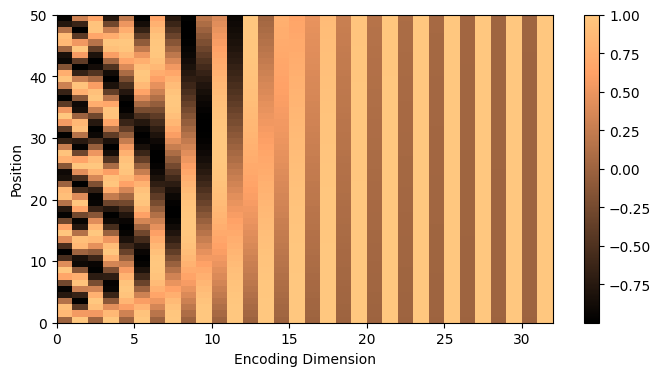

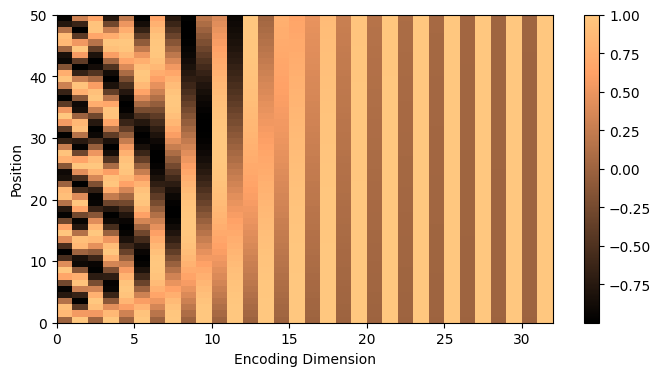

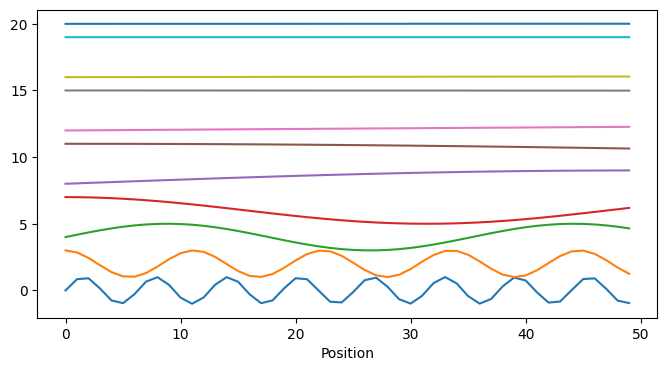

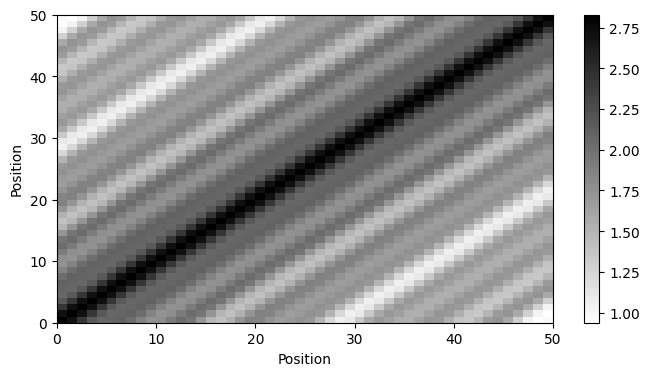

In [31]:
# sequence length 8, embedding size 4

def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''
    
    position = np.arange(n_position, dtype=np.float32).reshape(-1, 1) # (n_position, 1)
    index = np.arange(d_hid, dtype=np.float32) // 2
    div_term = np.power(10000.0, 2 * index / d_hid).reshape(1,-1) # (1, d_hid)  
    table = position / div_term # (n_position, d_hid)
    PE_table = np.zeros_like(table)
    PE_table[:, 0::2] = np.sin(table[:, 0::2]) # dim 2i
    PE_table[:, 1::2] = np.cos(table[:, 1::2]) # dim 2i+1
    
    return PE_table

def get_sinusoid_encoding_table2(n_position, d_hid):
    position = np.arange(n_position, dtype=np.float32).reshape(-1, 1) # (n_position, 1)
    div_term = np.exp(np.arange(0,d_hid,2, dtype=np.float32) * (-(math.log(10000.0) / d_model))) # (d_model/2, ))
    PE_table = np.zeros((n_position, d_hid))
    PE_table[:, 0::2] = np.sin(position * div_term)
    PE_table[:, 1::2] = np.cos(position * div_term)
    return PE_table

seq_len = 50
d_model = 32

PE_table1 = get_sinusoid_encoding_table(seq_len, d_model)
PE_table2 = get_sinusoid_encoding_table2(seq_len, d_model)
print(np.sum(np.abs(PE_table1 - PE_table2)**2))
print(np.allclose(PE_table1, PE_table2, atol=1e-5))

PE_table = PE_table1
plt.figure(figsize=(8, 4))
plt.pcolormesh(PE_table1, cmap='copper')
plt.xlabel('Encoding Dimension')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()        


plt.figure(figsize=(8, 4))
plt.pcolormesh(PE_table2, cmap='copper')
plt.xlabel('Encoding Dimension')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()        

# plot positional encoding vectoe of each position
plt.figure(figsize=(8, 4))
interval = d_model//10
for i in range(0, d_model, interval):
    plt.plot(PE_table[:, i] + 2 * i / interval, label='dim %d'%i)
plt.xlabel('Position')    


# dot product of positional encoding vectors
dot_product = np.matmul(PE_table, PE_table.T) / np.sqrt(d_model)
plt.figure(figsize=(8, 4))
plt.pcolormesh(dot_product, cmap='binary')
plt.xlabel('Position')
plt.ylabel('Position')
plt.colorbar()
plt.savefig('graph_new/transformer-future%d.png'%1)
plt.show()

    

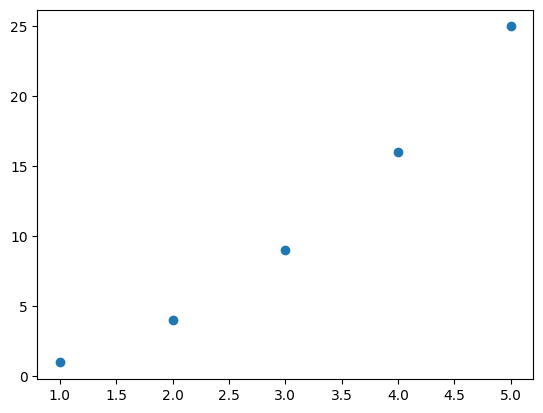

In [32]:

# Generate some data
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]

# Create a scatter plot
plt.scatter(x, y)

# Save the plot as a PNG file
plt.savefig('myplot.png')

# Display the plot
plt.show()

### Structure of The Model

Input of transformer:
   + use linear layer replace the embedding layer
   + use 1D convolutional layer replace embedding layer to capture the local temporal patterns.


In [33]:
# positional encoding
class PositionalEncoding(nn.Module):
    
    def __init__(self, embed_dim, max_seq_len=100, dtype=torch.float32):
        super(PositionalEncoding).__init__()
        position = torch.arange(0, max_seq_len, dtype=dtype).unsqueeze(1) # (max_seq_len, 1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=dtype) * (-(math.log(10000.0) / embed_dim))) # (embed_dim/2, ))
        PETable = torch.zeros(max_seq_len, embed_dim, dtype=dtype)
        PETable[:, 0::2] = torch.sin(position * div_term)
        PETable[:, 1::2] = torch.cos(position * div_term) # (max_seq_len, embed_dim)
        self.register_buffer('PETable', PETable)
    
    def forward(self, )
        
        

SyntaxError: expected ':' (1526153260.py, line 13)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)

input_window = 100
output_window = 5
batch_size = 10 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
       

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data():
    time        = np.arange(0, 400, 0.1)
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    
    
    sampels = 2800
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device)

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    
    return total_loss / i


def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.close()
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

train_data, val_data = get_data()


/tmp/ipykernel_951749/2325319568.py:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(inout_seq)


In [ ]:
print("train_data",train_data.shape)


train_data torch.Size([2695, 2, 100])


In [ ]:
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 10 is 0):
        val_loss = plot_and_loss(model, val_data,epoch)
        predict_future(model, val_data,200)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

#src = torch.rand(input_window, batch_size, 1) # (source sequence length,batch size,feature number) 
#out = model(src)
#
#print(out)
#print(out.shape)


In [ ]:
/home/tian/TIAN/GithubRepo/transformer-time-series-prediction/Test/0329_Notes_For_Implement_Transformer.ipynb

In [ ]:
# csv path
csv_path = '/home/tian/TIAN/GithubRepo/transformer-time-series-prediction/daily-min-temperatures.csv'
series = read_csv(csv_path, header=0, index_col=0, parse_dates=True, squeeze=True)
print(series.head())


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64


In [ ]:
2557347

In [ ]:
# get second column
tmep = series.values[:].reshape(-1,1)
tmep.shape


(3650, 1)